cpu


/home/sasha/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


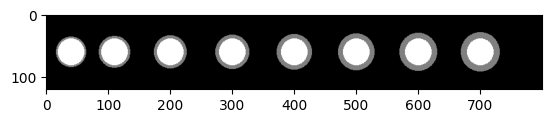

In [1]:
import numpy as np

import cv2
import matplotlib.pyplot as plt

import scipy
from scipy.interpolate import CubicSpline, lagrange
from scipy.optimize import curve_fit
from numpy.polynomial.polynomial import Polynomial
import random
import os
from skimage.draw import line
from scipy.ndimage import gaussian_filter1d

import torch
from torch.distributions.gamma import Gamma

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

from all import *
from transform import *
from draw import *


In [5]:
def detect_contours(img):
    mask_bord = cv2.inRange(img, 128,128)
    cont, hier = cv2.findContours(mask_bord, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ext = []
    int = []
    test = np.zeros_like(img)

    for i in range(len(cont)):
        mask_cont = np.zeros_like(img)

        if hier[0][i][3] == -1:
            mask_cont = cv2.drawContours(mask_cont, [cont[i]], 0, 200, 0)
            x, y, w, h = cv2.boundingRect(np.array(cont[i]))
            if (y != 0) and ((y + h) != mask_cont.shape[0]):
                cv2.drawContours(test, [cont[i]], 0, 128, 0)

                plt.imshow(mask_cont)
                nonzero = np.argwhere(mask_cont > 0)
                nonzero = np.array([list(reversed(nonz)) for nonz in nonzero])

                
                ext.append(nonzero)
            else:
                img[y:y+h, :] = 0


        else:
            mask_cont = cv2.drawContours(mask_cont, [cont[i]], 0, 1, 0)
            x, y, w, h = cv2.boundingRect(np.array(cont[i]))
            if (y != 0) and ((y + h) != mask_cont.shape[0]):
                cv2.drawContours(test, [cont[i]], 0, 255, 0)
                plt.imshow(mask_cont)
                nonzero = np.argwhere(mask_cont > 0)
                nonzero = np.array([list(reversed(nonz)) for nonz in nonzero])
                int.append(nonzero)
            else:
                img[y:y+h, :] = 0

    plt.imshow(test)

    return ext, int, img

In [6]:
def closest_point(point, array):
     diff = array - point
     distance = np.einsum('ij,ij->i', diff, diff)
     return np.argmin(distance), distance

def parabola(x, a, b, c):
    return a*x**2 + b*x + c


def draw_gradient_line(img, start_point, points, colors, thickness=4, flag=None):
    start = start_point
    if flag is None:
        for i in range(1, len(points) - 1):
            # if img[start[1], start[0]] == 0 or img[start[1], start[0]] == 255 or img[start[1], start[0]]==128:
            cv2.line(img, start, points[i+1], colors[i], thickness)
            start = points[i]
    elif flag == 'ext':
        for i in range(1, len(points) - 1):
            if img[start[1], start[0]] == 0 or img[start[1], start[0]] == 255 or img[start[1], start[0]]==128:
                print(start)
                cv2.line(img, start, points[i+1], colors[i], thickness)
                start = points[i]



def compute_previous_pixel(first_pixel, last_pixel, distance=1):
    x1, y1 = first_pixel
    x2, y2 = last_pixel

    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    t = -distance / length
    x_t = np.round((x1 + t * (x2 - x1)), 0).astype(np.int32)
    y_t = np.round((y1 + t * (y2 - y1)), 0).astype(np.int32)

    return (x_t, y_t)

def compute_next_pixel(first_point, last_point, distance=1):
    x1, y1 = first_point
    x2, y2 = last_point

    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    t = 1 + distance / length
    x_t = np.round((x1 + t * (x2 - x1)), 0).astype(np.int32)
    y_t = np.round((y1 + t * (y2 - y1)), 0).astype(np.int32)

    return (x_t, y_t)

In [7]:
def formula_second(img, angles, color_map, k, file_name, save_dir):
    signal = np.zeros_like(img, dtype=np.float32)


    alpha_bord = angles[img == 128]

    alpha_bord[alpha_bord==alpha_bord.min()] = np.radians(1)

    alpha_back = angles[img == 0]
    alpha_hole = angles[img == 255]

    # k = k
    signal[img == 0] = (k*(1/(np.abs(np.cos(np.radians(alpha_back + 1)))**(0.87)) - 1) + 1) * color_map[img==0]

    signal[img == 128] = (k * (1/(np.abs(np.cos(np.radians(90)-(np.radians(180 - 90) - alpha_bord)))**(0.87)) - 1) + 1) *color_map[img==128]


    signal[img == 255] = (k * (1 / (np.abs(np.cos(np.radians(alpha_hole + 1)))**(1.1)) - 1) + 1) * color_map[img==255]

    signal = np.clip(signal, 0, 255)
    signal = cv2.GaussianBlur(signal, (3, 3), 0)

    # cv2.imwrite(f'{save_dir}{file_name[:-4]}_signal_k{k}_6.png', signal.astype(np.uint8))
    cv2.imwrite(f'{save_dir}/{file_name[:-4]}.png', signal.astype(np.uint8))


    return signal

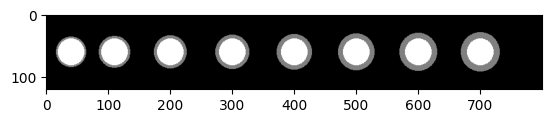

True

In [8]:
def simulate_circles():
    image_hole = np.zeros((120, 800), dtype=np.float32)
    center_coordinates1 = (40, 60)
    center_coordinates2 = (110, 60)
    center_coordinates3 = (200, 60)
    center_coordinates4 = (300, 60)
    center_coordinates5 = (400, 60)
    center_coordinates6 = (500, 60)
    center_coordinates7 = (600, 60)
    center_coordinates8 = (700, 60)



    radius = 20

    color_border = (128, 0, 0)
    color_hole = (255, 0, 0)
    
    thickness_border = -1
    thickness_hole = -1

    # border 3
    image_border = cv2.circle(image_hole, center_coordinates1, radius+3, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates1, radius+3, color_border, thickness_border)
    image_hole = cv2.circle(image_border, center_coordinates1, radius, color_hole,2)
    image_hole = cv2.circle(image_hole, center_coordinates1, radius, color_hole, thickness_hole)

    # border 4
    image_border = cv2.circle(image_hole, center_coordinates2, radius+4, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates2, radius+4, color_border, thickness_border)
    image_hole = cv2.circle(image_border, center_coordinates2, radius, color_hole,2)
    image_hole = cv2.circle(image_hole, center_coordinates2, radius, color_hole, thickness_hole)

    # border 5
    image_border = cv2.circle(image_hole, center_coordinates3, radius+5, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates3, radius+5, color_border, thickness_border)
    image_hole = cv2.circle(image_border, center_coordinates3, radius, color_hole,2)
    image_hole = cv2.circle(image_hole, center_coordinates3, radius, color_hole, thickness_hole)

    # border 6
    image_border = cv2.circle(image_hole, center_coordinates4, radius+6, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates4, radius+6, color_border, thickness_border)
    image_hole = cv2.circle(image_border, center_coordinates4, radius, color_hole,2)
    image_hole = cv2.circle(image_hole, center_coordinates4, radius, color_hole, thickness_hole)

    # border 7
    image_border = cv2.circle(image_hole, center_coordinates5, radius+7, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates5, radius+7, color_border, thickness_border)
    image_hole = cv2.circle(image_border, center_coordinates5, radius, color_hole,2)
    image_hole = cv2.circle(image_hole, center_coordinates5, radius, color_hole, thickness_hole)

    # border 8
    image_border = cv2.circle(image_hole, center_coordinates6, radius+8, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates6, radius+8, color_border, thickness_border)
    image_hole = cv2.circle(image_border, center_coordinates6, radius, color_hole,2)
    image_hole = cv2.circle(image_hole, center_coordinates6, radius, color_hole, thickness_hole)

    # border 9
    image_border = cv2.circle(image_hole, center_coordinates7, radius+9, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates7, radius+9, color_border, thickness_border)
    image_hole = cv2.circle(image_border, center_coordinates7, radius, color_hole,2)
    image_hole = cv2.circle(image_hole, center_coordinates7, radius, color_hole, thickness_hole)

    # border 10
    image_border = cv2.circle(image_hole, center_coordinates8, radius+10, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates8, radius+10, color_border, thickness_border)
    image_hole = cv2.circle(image_border, center_coordinates8, radius, color_hole,2)
    image_hole = cv2.circle(image_hole, center_coordinates8, radius, color_hole, thickness_hole)

    plt.imshow(image_hole, cmap='gray')
    plt.show()

    # cv2.imwrite('./data/test_img_two.png', image_border)
    return image_border

img_circles = simulate_circles()
cv2.imwrite('difr_circles.png', np.clip(img_circles, 0, 255))


In [42]:
def transform(circle2, ext, int):
    color_back = 110
    color_hole = 85

    width_img = np.zeros_like(circle2, dtype=np.float32)
    angles_img = np.zeros_like(circle2, dtype=np.float32)
    new_angles = np.zeros_like(circle2, dtype=np.float32)
    color_map = np.zeros_like(circle2, dtype=np.float32)
    color_map[circle2 == 0] = color_back
    color_map[circle2 == 255] = color_hole


    for cont_ext, cont_int in zip(ext, int):
        for point in cont_ext:
                min_dist = float('inf')
                index, dist = closest_point(point, cont_int)
                if dist[index] < min_dist :
                    min_dist = dist[index].item()
                    nearest_point = cont_int[index] 
                    if nearest_point[0] == point[0] and nearest_point[1] == point[1]:
                        dist_ = 1
                    else:
                        dist_ = np.sqrt((point[0] - nearest_point[0])**2 + (point[1] - nearest_point[1])**2).astype(np.int32)
                        # print(min_dist, dist_)
                        dist_ = dist_.item()
                dist_ += 1
                
                if dist_ == 0:
                    dist_ = 1
                discrete_line = list(zip(*line(*point, *nearest_point))) # find all pixels from the line
                # discrete_line_x = np.array(list(zip(*discrete_line))[0])
                if len(discrete_line) > 1:
                    mid_point = [(point[0] + nearest_point[0])//2, (point[1] + nearest_point[1])//2]
                    prev = [compute_previous_pixel(point, nearest_point)]
                    next = [compute_next_pixel(point, nearest_point)]
                # print(next)

                angle = np.arctan(700 / (dist_ * 12))
                cv2.line(width_img, point, nearest_point, dist_, 3)
                cv2.line(angles_img, point, nearest_point, angle, 2)

                if len(discrete_line) == 1:
                    height_vals = [color_back - 2]
                    discrete_line_ = discrete_line

                else:
                    height_vals = [((k_ * ((color_back - color_hole) / dist_)) + color_hole) for k_ in range(0, dist_+2)]
                    discrete_line_ = discrete_line + next

                draw_gradient_line(color_map, point, discrete_line_, height_vals, thickness=3)

                # calculate new angles
                if dist_ >= 3:

                    # firct variant

                    # if dist_ > 5:
                        k = dist_/10
                        # if k > 1:
                        # print(dist, k, angle)
                        # if k < 1:
                        #     val = angle*k
                        # else:
                        #     val = angle/k
                        val = angle * 0.9

                        y_mean = val
                        y_0 = val/2
                        y_n = val/2
                        x_plot = np.arange(0, len(discrete_line))
                        coefs = curve_fit(parabola, [x_plot[0], x_plot[len(x_plot)//2], x_plot[-1]], [y_0, y_mean, y_n])
                        a,b,c = coefs[0]
                        y_parabola = parabola(x_plot, a, b, c)
                        heights = y_parabola
                        draw_gradient_line(new_angles, point, discrete_line, np.abs(y_parabola), thickness=5)
                    # else:
                    #     val = angle
                    #     cv2.line(new_angles, point, nearest_point, val, 4)
                    # val = np.arctan(700/(dist_+2))*0.9

                    # if dist_ <= 5:
                    #     k = dist_/10
                    #     val = np.abs(angle*(1-k) * 0.95)

                    #     # val = angle*(1-k) * 0.95
                    # else:
                    #     k = dist_/5
                    # val = np.abs(angle*(1-k) * 0.95)
                    # if k < 1:
                    #     val = angle*(1-k) * 0.95
                        # val = angle/k * 0.95

                    # else:
                        # val = angle/k * 0.95


                    # ___ added - плохо видно широкую границу 9-10 пикселей

                    # if dist_ > 6:
                        # dist_ = 6
                    # k = (dist_-2)/10
                    # val = angle * (1 - k)
                    # val = angle * (1 - k)

                    # another add
                    # val = 0.9 * angle

                    # added second - пытаюсь улучшить видимость широкой границы
                    # if dist_>=8:
                    #     val = val * 1.1
                    # print(dist_, angle, k, val)

                    # y_mean = val
                    # y_0 = val/2
                    # y_n = val/2
                    # y_0 = val/6
                    # y_n = val/6
                    # x_plot = np.arange(0, len(discrete_line)+2)
                    # x_plot = np.arange(0, len(discrete_line))

                    # x_plot = np.arange(0, len(discrete_line)+1)

                    # coefs = curve_fit(parabola, [x_plot[0], x_plot[len(x_plot)//2], x_plot[-1]], [y_0, y_mean, y_n])
                    # coefs = curve_fit(parabola, [x_plot[0], x_plot[len(x_plot)//2 - 1], x_plot[-1]], [y_0, y_mean, y_n])
                    # coefs = curve_fit(parabola, [x_plot[0], x_plot[1], x_plot[len(x_plot)//2 - 1], x_plot[-2], x_plot[-1]], [0, y_0, y_mean, y_n, 0])


                    # a,b,c = coefs[0]
                    # y_parabola = parabola(x_plot, a, b, c)
                    # y_parabola = blur(y_parabola)
                    # y_parabola =  gaussian_filter1d(y_parabola, 3)
                    # heights = y_parabola
                    # if dist_ > 10:
                    #     thickness = 5
                    # else:
                    #     thickness = 5
                    # discrete_line_ = prev + discrete_line + next
                    # discrete_line_ = discrete_line

                    # discrete_line_ = prev + discrete_line

                    # draw_gradient_line(new_angles, point, discrete_line_, y_parabola, thickness=thickness)


    for cont_ext, cont_int in zip(ext, int):
        for point in cont_int:
                min_dist = float('inf')
                index, dist = closest_point(point, cont_ext)
                if dist[index] < min_dist :
                    min_dist = dist[index].item()
                    nearest_point = cont_ext[index]
                    if nearest_point[0] == point[0] and nearest_point[1] == point[1]:
                        dist_ = 1
                    else:
                        # print((point[0] - nearest_point[0])**2 + (point[1] - nearest_point[1]))
                        dist_ = np.sqrt((point[0] - nearest_point[0])**2 + (point[1] - nearest_point[1])**2).astype(np.int32)
                        # print(min_dist, dist_)
                        dist_ = dist_.item()
                dist_ += 1
                if dist_ == 0:
                    dist_ = 1

                # if dist_ > 10:
                #     dist_ = 10
                discrete_line = list(zip(*line(*point, *nearest_point))) # find all pixels from the line
                # discrete_line_x = np.array(list(zip(*discrete_line))[0])
                if len(discrete_line) > 1:
                    mid_point = [(point[0] + nearest_point[0])//2, (point[1] + nearest_point[1])//2]
                    prev = [compute_previous_pixel(point, nearest_point)]
                    next = [compute_next_pixel(point, nearest_point)]

                angle = np.arctan(700 / (dist_ * 12))
                cv2.line(width_img, point, nearest_point, dist_, 3)
                cv2.line(angles_img, point, nearest_point, angle, 2)

                if len(discrete_line) == 1:
                    height_vals = [color_back - 2]
                    discrete_line_ =discrete_line

                else:
                    height_vals = [((k_ * ((color_back - color_hole) / dist_)) + color_hole) for k_ in range(1, dist_+2)]
                    discrete_line_ = discrete_line + next

                # discrete_line_ =discrete_line + next
                draw_gradient_line(color_map, point, discrete_line_, height_vals, thickness=3)


                # calculate new angles
                if dist_ >= 3:

                    # firct variant

                    # if dist_ > 5:
                    #     k = dist_/10
                    #     # if k > 1:
                    #     # print(dist, k, angle)
                    #     if k < 1:
                    #         val = angle*k
                    #     else:
                    #         val = angle/k

                        val = angle * 0.9
                        y_mean = val
                        y_0 = val/2
                        y_n = val/2
                        x_plot = np.arange(0, len(discrete_line))
                        coefs = curve_fit(parabola, [x_plot[0], x_plot[len(x_plot)//2], x_plot[-1]], [y_0, y_mean, y_n])
                        a,b,c = coefs[0]
                        y_parabola = parabola(x_plot, a, b, c)
                        heights = y_parabola
                        draw_gradient_line(new_angles, point, discrete_line, np.abs(y_parabola), thickness=5)
                    # else:
                    #     val = angle
                    #     cv2.line(new_angles, point, nearest_point, val, 4)

                    # val = np.arctan(700/(dist_+2))*0.9

                    # if dist_ <= 5:
                    #     k = dist_/10
                    #     val = np.abs(angle*(1-k) * 0.95)

                    #     # val = angle*(1-k) * 0.95
                    # else:
                    #     k = dist_/5
                    # val = np.abs(angle*(1-k) * 0.95)
                    # if k < 1:
                    #     val = angle*(1-k) * 0.95
                        # val = angle/k * 0.95

                    # else:
                        # val = angle/k * 0.95


                    # ___ added - плохо видно широкую границу 9-10 пикселей

                    # if dist_ > 6:
                        # dist_ = 6
                    # k = (dist_-2)/10
                    # val = angle * (1 - k)
                    # val = angle * (1 - k)

                    # another add
                    # val = 0.9 * angle

                    # added second - пытаюсь улучшить видимость широкой границы
                    # if dist_>=8:
                    #     val = val * 1.1
                    # val = angle * 0.9
                    # print(dist_, angle, k, val)

                    # y_mean = val
                    # y_0 = val/2
                    # y_n = val/2
                    
                    # y_0 = val/6
                    # y_n = val/6
                    # x_plot = np.arange(0, len(discrete_line)+2)
                    # x_plot = np.arange(0, len(discrete_line))

                    # x_plot = np.arange(0, len(discrete_line)+1)

                    # coefs = curve_fit(parabola, [x_plot[0], x_plot[len(x_plot)//2], x_plot[-1]], [y_0, y_mean, y_n])
                    # coefs = curve_fit(parabola, [x_plot[0], x_plot[len(x_plot)//2 - 1], x_plot[-1]], [y_0, y_mean, y_n])

                    # coefs = curve_fit(parabola, [x_plot[0], x_plot[1], x_plot[len(x_plot)//2 - 1], x_plot[-2], x_plot[-1]], [0, y_0, y_mean, y_n, 0])


                    # a,b,c = coefs[0]
                    # y_parabola = parabola(x_plot, a, b, c)

                    # if dist_ > 10:
                    #     thickness = 5
                    # else:
                    #     thickness = 3
                    
                    # # discrete_line_ = prev + discrete_line + next
                    # discrete_line_ = discrete_line

                    # # discrete_line_ = prev + discrete_line

                    # draw_gradient_line(new_angles, point, discrete_line_, y_parabola, thickness=thickness)

    # print(np.unique(width_img == 3))
    # print(np.unique(width_img))
    mask_width = width_img == 3

    if len(np.unique(mask_width))>1:
    # print(np.unique(new_angles))
        val3 = np.max(new_angles[mask_width])
        new_angles[width_img == 2] = val3*1.001
        new_angles[width_img == 1] = val3*1.002
    else:
        new_angles[width_img == 2] = angles_img[width_img == 2] * 0.9
        new_angles[width_img == 1] = angles_img[width_img == 1] * 0.9

    mask = circle2 != 128 

    width_img[mask] = 0
    angles_img[mask] = 0

    color_map[circle2 == 0] = color_back
    color_map[circle2 == 255] = color_hole

    # mask2 = width_img < 4
    new_angles_copy = new_angles.copy()
    new_angles = cv2.GaussianBlur(new_angles, (7, 7), 0)
    # new_angles[mask2] = new_angles_copy[mask2]
    new_angles[mask] = 0
    angles_img = cv2.GaussianBlur(angles_img, (7, 7), 0)
    # angles_img = cv2.GaussianBlur(angles_img, (3, 3), 0)

    color_map = cv2.GaussianBlur(color_map, (7, 7), 0)

    # return width_img, angles_img, new_angles, color_map
    return width_img


In [43]:
circle2 = img_circles.copy()


/home/sasha/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


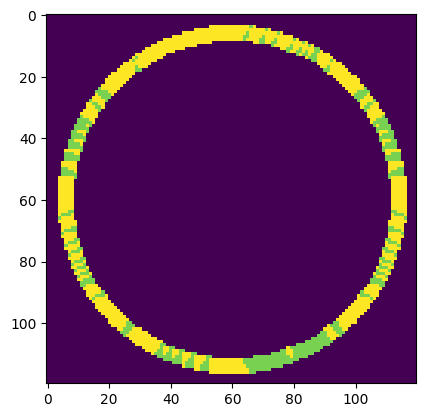

In [44]:
ext, int, circle2 = detect_contours(circle2)
width_img= transform(circle2, ext, int)

plt.imshow(width_img)
# signal_second = formula_second(circle2, new_angles, color_map, 0.3,'signal_circles.png', './')

## one circle

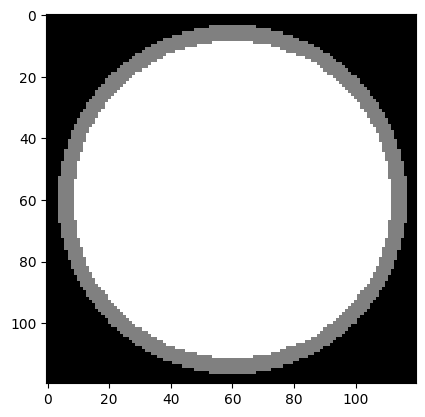

True

In [45]:
def simulate_circle(w = 5):
    image_hole = np.zeros((120, 120), dtype=np.float32)
    center_coordinates1 = (60, 60)
    # center_coordinates2 = (110, 60)
    # center_coordinates3 = (200, 60)
    # center_coordinates4 = (300, 60)
    # center_coordinates5 = (400, 60)
    # center_coordinates6 = (500, 60)
    # center_coordinates7 = (600, 60)
    # center_coordinates8 = (700, 60)



    radius = 50

    color_border = (128, 0, 0)
    color_hole = (255, 0, 0)
    
    thickness_border = -1
    thickness_hole = -1

    # border 3
    image_border = cv2.circle(image_hole, center_coordinates1, radius+w, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates1, radius+w, color_border, thickness_border)
    image_hole = cv2.circle(image_border, center_coordinates1, radius, color_hole,2)
    image_hole = cv2.circle(image_hole, center_coordinates1, radius, color_hole, thickness_hole)

    # # border 4
    # image_border = cv2.circle(image_hole, center_coordinates2, radius+4, color_border, 2)
    # image_border = cv2.circle(image_border, center_coordinates2, radius+4, color_border, thickness_border)
    # image_hole = cv2.circle(image_border, center_coordinates2, radius, color_hole,2)
    # image_hole = cv2.circle(image_hole, center_coordinates2, radius, color_hole, thickness_hole)

    # # border 5
    # image_border = cv2.circle(image_hole, center_coordinates3, radius+5, color_border, 2)
    # image_border = cv2.circle(image_border, center_coordinates3, radius+5, color_border, thickness_border)
    # image_hole = cv2.circle(image_border, center_coordinates3, radius, color_hole,2)
    # image_hole = cv2.circle(image_hole, center_coordinates3, radius, color_hole, thickness_hole)

    # # border 6
    # image_border = cv2.circle(image_hole, center_coordinates4, radius+6, color_border, 2)
    # image_border = cv2.circle(image_border, center_coordinates4, radius+6, color_border, thickness_border)
    # image_hole = cv2.circle(image_border, center_coordinates4, radius, color_hole,2)
    # image_hole = cv2.circle(image_hole, center_coordinates4, radius, color_hole, thickness_hole)

    # # border 7
    # image_border = cv2.circle(image_hole, center_coordinates5, radius+7, color_border, 2)
    # image_border = cv2.circle(image_border, center_coordinates5, radius+7, color_border, thickness_border)
    # image_hole = cv2.circle(image_border, center_coordinates5, radius, color_hole,2)
    # image_hole = cv2.circle(image_hole, center_coordinates5, radius, color_hole, thickness_hole)

    # # border 8
    # image_border = cv2.circle(image_hole, center_coordinates6, radius+8, color_border, 2)
    # image_border = cv2.circle(image_border, center_coordinates6, radius+8, color_border, thickness_border)
    # image_hole = cv2.circle(image_border, center_coordinates6, radius, color_hole,2)
    # image_hole = cv2.circle(image_hole, center_coordinates6, radius, color_hole, thickness_hole)

    # # border 9
    # image_border = cv2.circle(image_hole, center_coordinates7, radius+9, color_border, 2)
    # image_border = cv2.circle(image_border, center_coordinates7, radius+9, color_border, thickness_border)
    # image_hole = cv2.circle(image_border, center_coordinates7, radius, color_hole,2)
    # image_hole = cv2.circle(image_hole, center_coordinates7, radius, color_hole, thickness_hole)

    # # border 10
    # image_border = cv2.circle(image_hole, center_coordinates8, radius+10, color_border, 2)
    # image_border = cv2.circle(image_border, center_coordinates8, radius+10, color_border, thickness_border)
    # image_hole = cv2.circle(image_border, center_coordinates8, radius, color_hole,2)
    # image_hole = cv2.circle(image_hole, center_coordinates8, radius, color_hole, thickness_hole)

    plt.imshow(image_hole, cmap='gray')
    plt.show()

    # cv2.imwrite('./data/test_img_two.png', image_border)
    return image_border

circle = simulate_circle(w = 5)
cv2.imwrite('circle.png', np.clip(img_circles, 0, 255))


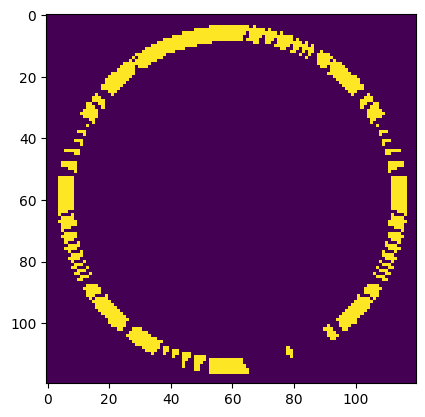

In [47]:
ext, int, circle2 = detect_contours(circle)
width_img_circle  = transform(circle, ext, int)

plt.imshow(width_img_circle)